In [1]:
import numpy as np
import pandas as pd
import random
from helper_funcs_nonnormaleps import *
seed = 1 # for reproducibility. needed to get the same random sample each time


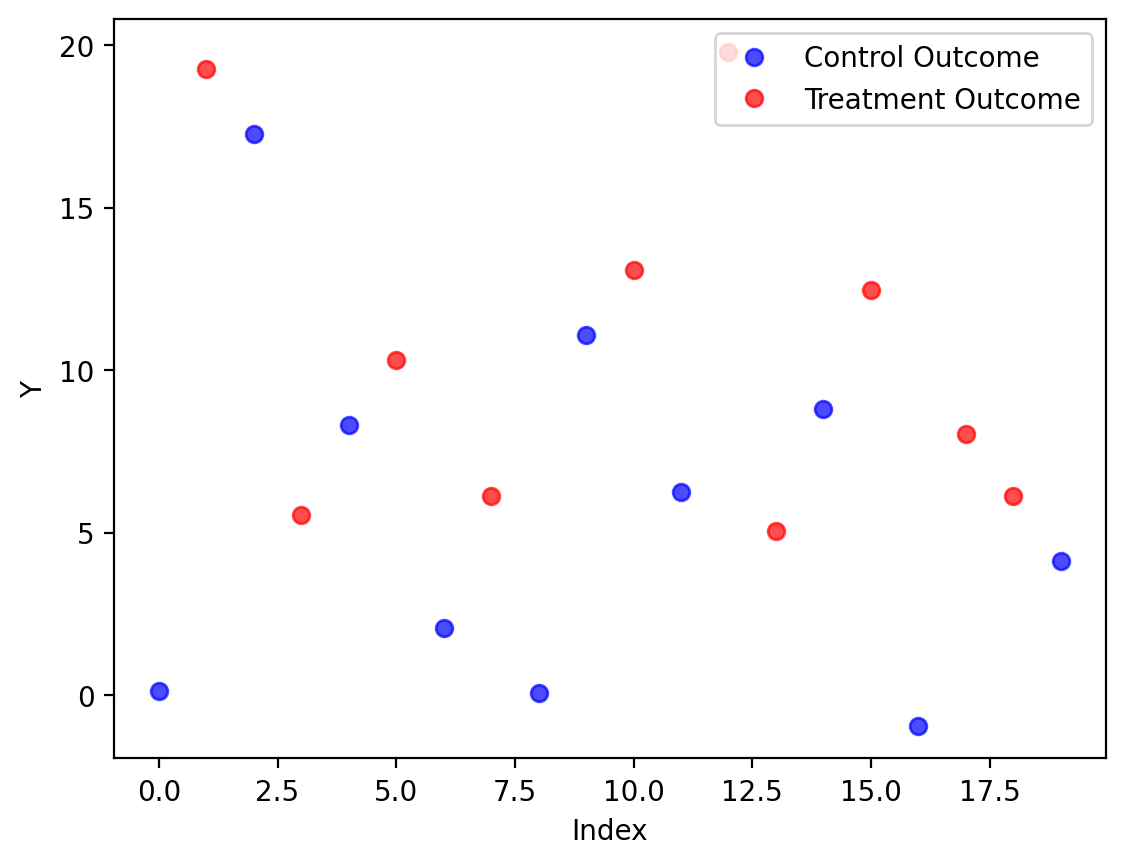

In [2]:
np.random.seed(seed)
random.seed(seed)
small_sample_size = 10
te = 2
x, y = gen_base_data()
exp_data = gen_exp_data(x,y,small_sample_size,2)
# we don't want to plot with respect to x, since we are dealing with difference in means
# we can shuffle the data to get rid of this relationship and plot against index instead of x
d = {'outcomes': np.append(exp_data['control_y'], exp_data['treat_y']), 
     'treatment': np.append(np.zeros(small_sample_size), np.ones(small_sample_size))}
df = pd.DataFrame(data = d).sample(frac=1,random_state = 1, ignore_index = True)
temp_exp_data = exp_data.copy()
temp_exp_data['control_x'] = df.index[df['treatment'] == 0]
temp_exp_data['treat_x'] = df.index[df['treatment'] == 1]
plot_instance(temp_exp_data, 'Index', 'Y', save_name = "nonnorm_plots/Simulated_y_indx.png")

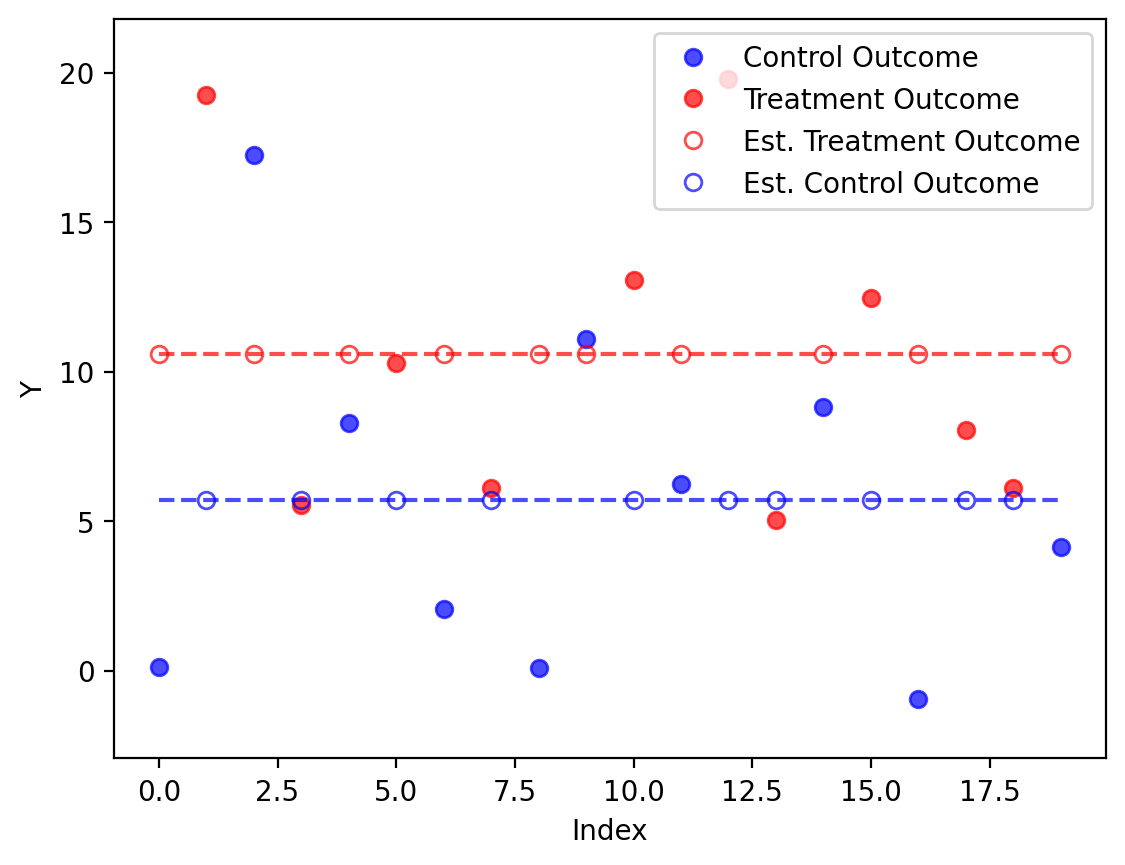

ATE:  4.864785946041433 , SE:  2.5241069317046883


In [3]:
# define constant model 
def const_mod(x):
    return np.zeros(len(x))
alpha_1 = np.mean(temp_exp_data['treat_y'])
alpha_0 = np.mean(temp_exp_data['control_y'])
cf_dict = gen_counter_data(range(small_sample_size*2),temp_exp_data,const_mod,alpha_1, alpha_0)
plot_instance(temp_exp_data, 'Index','Y',cf_dict = cf_dict, save_name = "nonnorm_plots/Constant_poe.png")

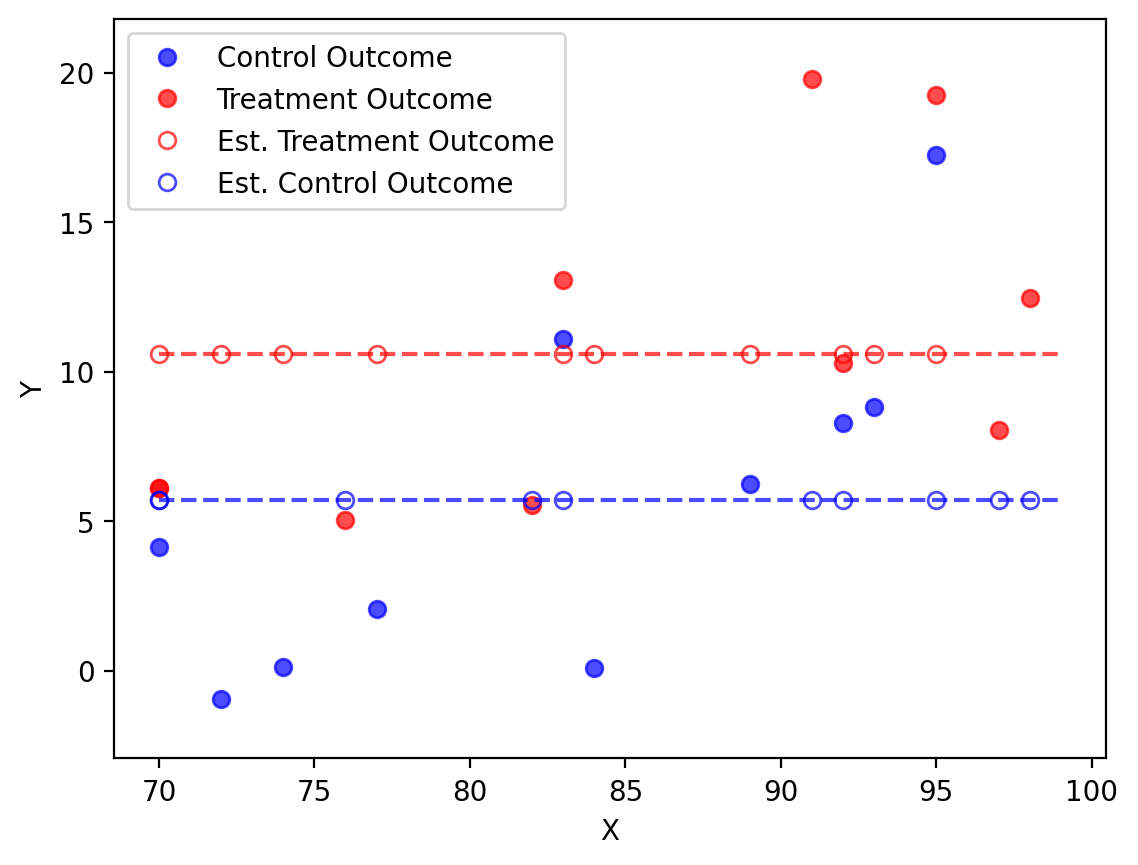

ATE:  4.864785946041433 , SE:  2.5241069317046883


In [4]:
# plot for constant model but ordered by covariate x
cf_dict = gen_counter_data(x,exp_data,const_mod,alpha_1, alpha_0)
plot_instance(exp_data, 'X','Y',cf_dict = cf_dict, save_name = "nonnorm_plots/Constant_poe_x.png")

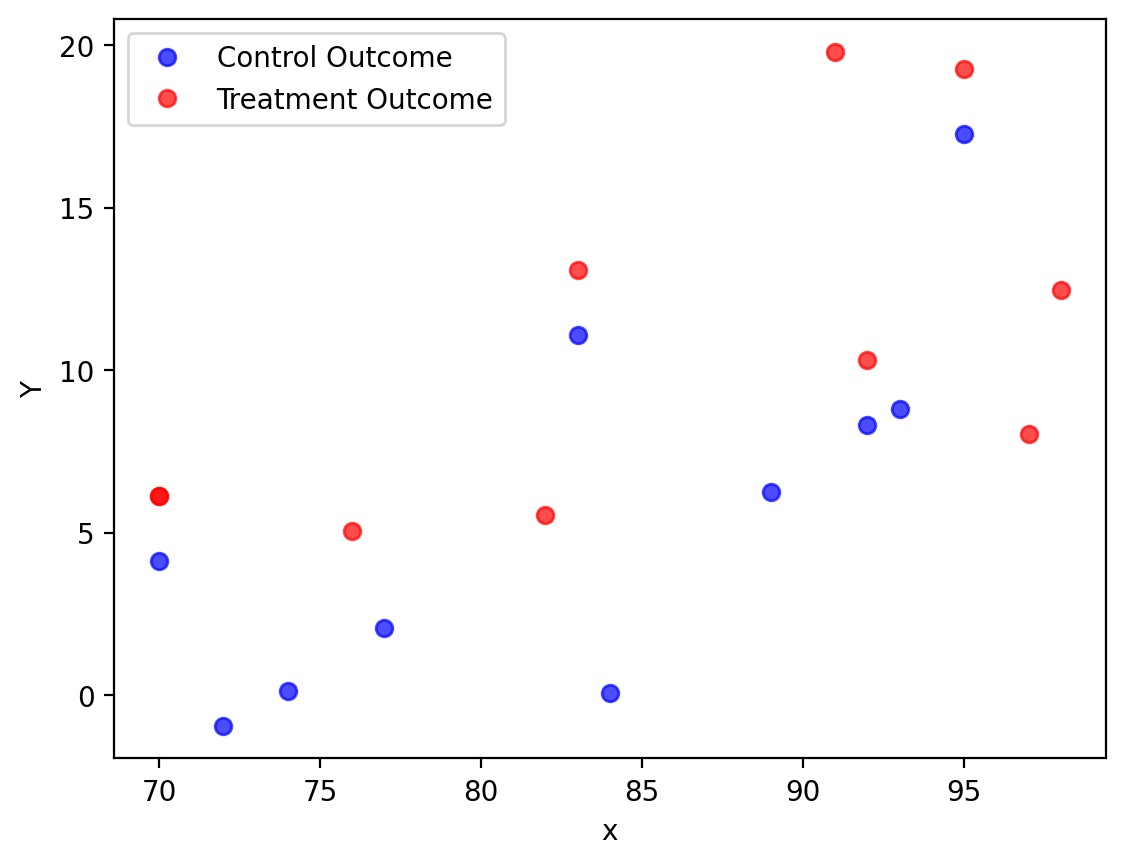

In [5]:
# Now, move on to regression model
# we first plot the data but now with respect to covariate x
plot_instance(exp_data, 'x', 'Y',save_name="nonnorm_plots/Simulated_y_reg_points.png")

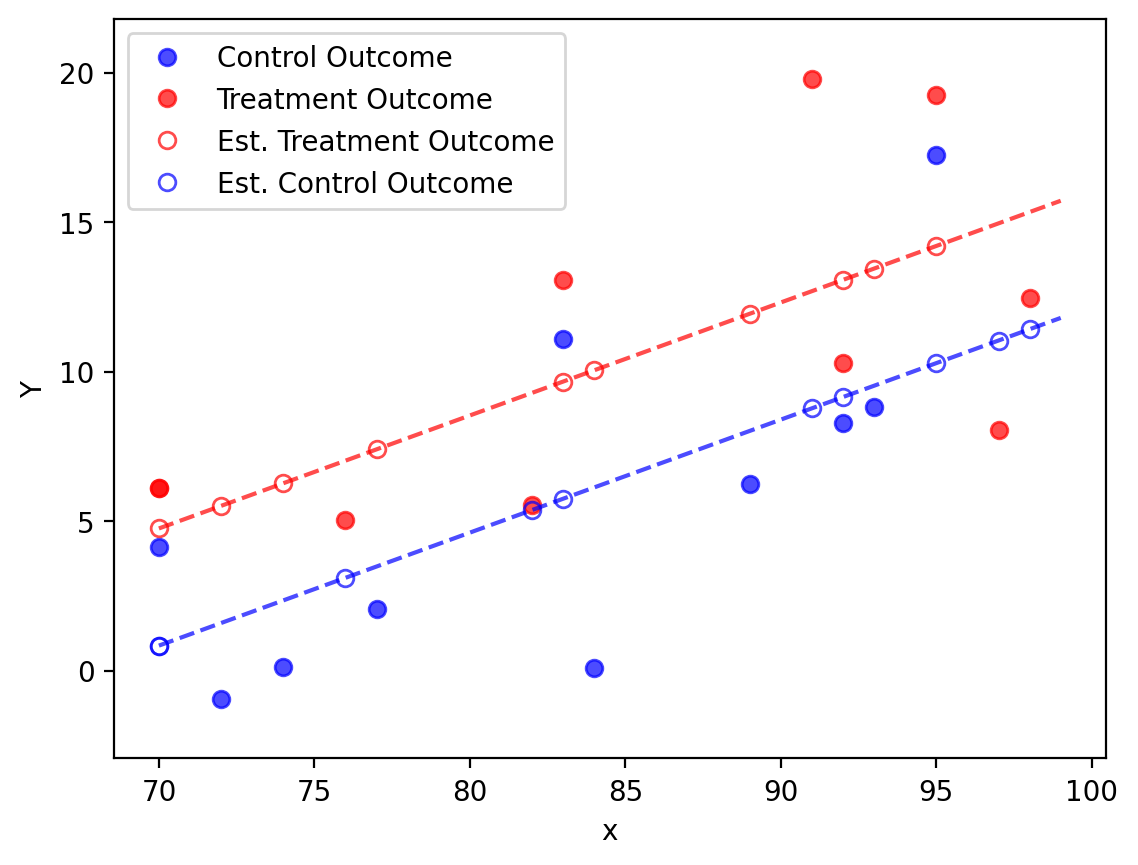

ATE:  3.9196545321159904 , SE:  1.8702599202485046


In [6]:
# Then, we can fit regression model to describe counterfactuals 
# first compute beta 
treatxvar = np.var(exp_data['treat_x'], ddof = 1)
controlxvar = np.var(exp_data['control_x'], ddof = 1)
treatxcov = np.cov(exp_data['treat_x'], exp_data['treat_y'], ddof=1)[0,1]
controlxcov = np.cov(exp_data['control_x'], exp_data['control_y'], ddof=1)[0,1]
beta = (treatxcov + controlxcov) / (treatxvar + controlxvar)
alpha_1 = np.mean(exp_data['treat_y']) - np.mean(exp_data['treat_x'])*beta
alpha_0 = np.mean(exp_data['control_y']) - np.mean(exp_data['control_x'])*beta
# define the regression mod without intercepts 
def regress_mod(x):
    return x*beta
# generate counterfactual data
cf_dict = gen_counter_data(x, exp_data, regress_mod, alpha_1, alpha_0)
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, save_name="nonnorm_plots/Simulated_y_regression.png")


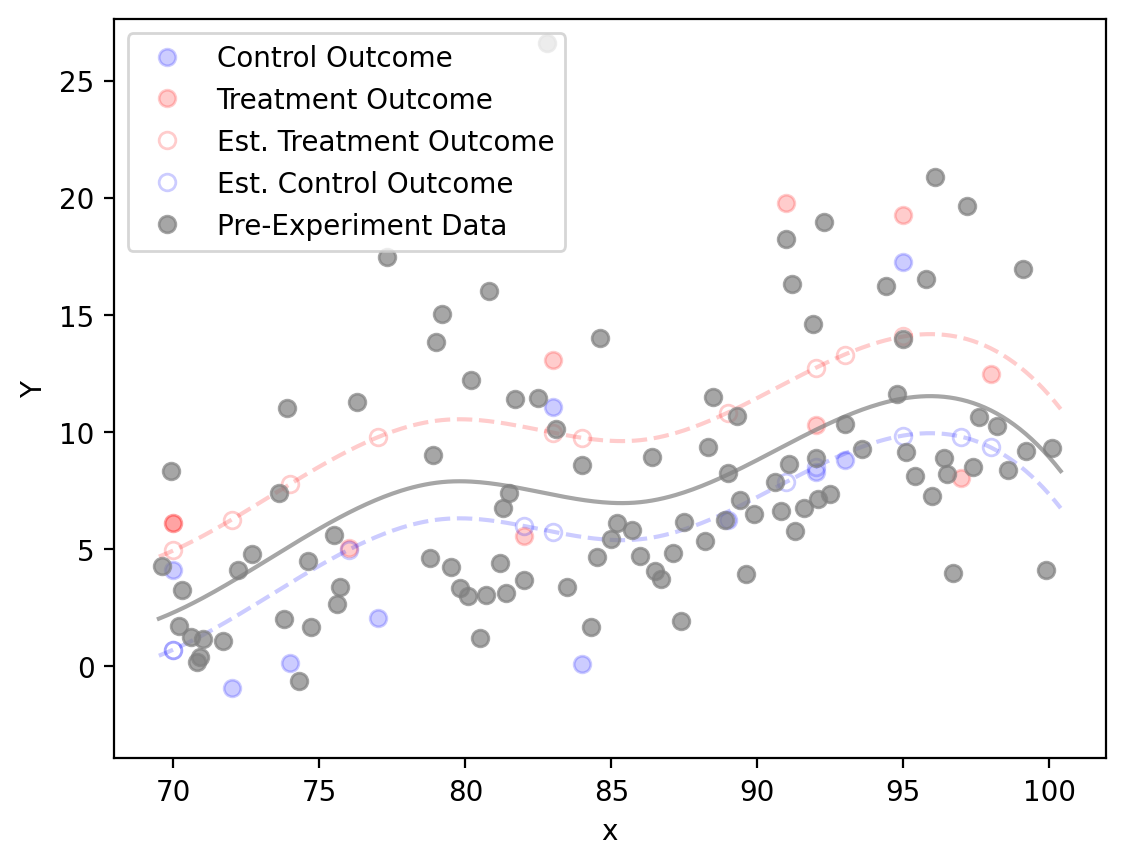

ATE:  4.229932434645649 , SE:  1.93714015496227


In [7]:
# Now, we move on to using pre_experiment data
# generate pre-exp data
np.random.seed(seed)
random.seed(seed)
pre_exp_data = gen_pre_exp_data(smoothing_param=2000)

# generate cf estimates using pre-experiment model
def pre_exp_model(x):
    mod = pre_exp_data['model']
    return mod(x)
alpha_1 = np.mean(exp_data['treat_y'] - pre_exp_model(exp_data['treat_x']))
alpha_0 = np.mean(exp_data['control_y'] - pre_exp_model(exp_data['control_x']))
cf_dict = gen_counter_data(pre_exp_data['fine_x'], exp_data, pre_exp_model, alpha_1, alpha_0)
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, pre_exp_dict = pre_exp_data, flip_alpha = True, save_name="nonnorm_plots/preexp_preds.png")

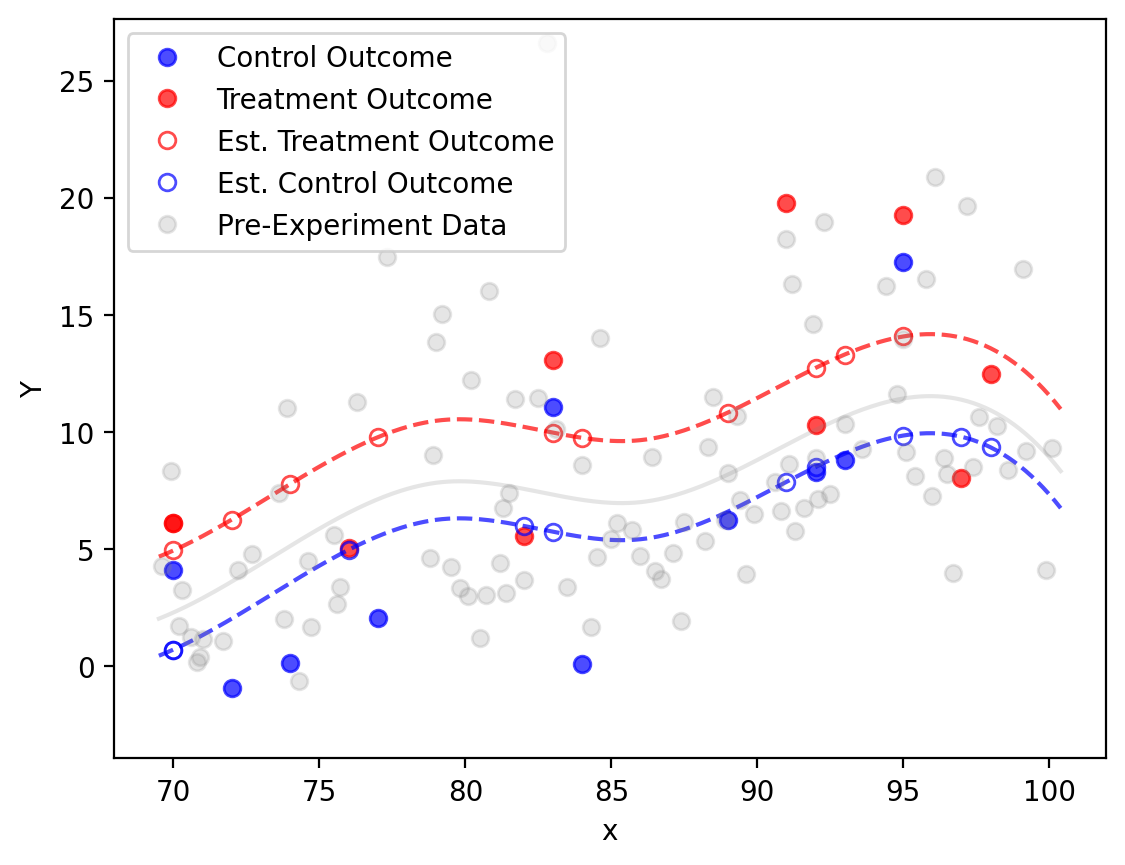

ATE:  4.229932434645649 , SE:  1.93714015496227


In [8]:
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, pre_exp_dict = pre_exp_data, save_name="nonnorm_plots/preexp_cf.png")

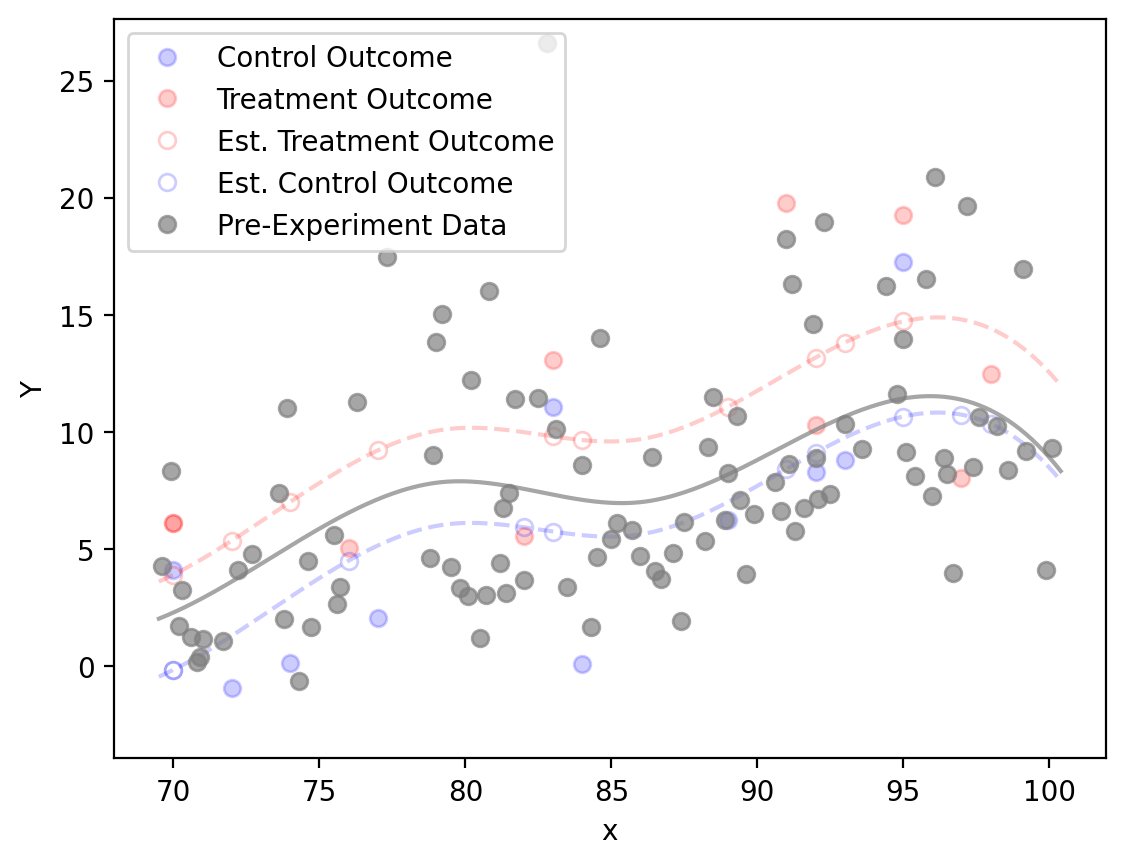

ATE:  4.062444996812863 , SE:  1.9137088734567829


In [9]:
# finally, we apply linear adjustments to the predictions 
treat_pred = pre_exp_model(exp_data['treat_x'])
control_pred = pre_exp_model(exp_data['control_x'])
control_r = exp_data['control_y'] - control_pred
treat_r = exp_data['treat_y'] - treat_pred

# whether we center it or not, doesn't matter. Regression estimator doesn't depend on the mean
treatxcov = np.cov(exp_data['treat_x'], treat_r)[0,1]
controlxcov = np.cov(exp_data['control_x'], control_r)[0,1]
beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
alpha_1 = np.mean(treat_r) - np.mean(exp_data['treat_x'])*beta
alpha_0 = np.mean(control_r) - np.mean(exp_data['control_x'])*beta

# define the two_stage model
def two_stage_mod(x):
    mod = pre_exp_data['model']
    return x * beta + mod(x)

cf_dict = gen_counter_data(pre_exp_data['fine_x'], exp_data, two_stage_mod, alpha_1, alpha_0)
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, pre_exp_dict = pre_exp_data, flip_alpha = True, save_name="nonnorm_plots/sec_preexp.png")



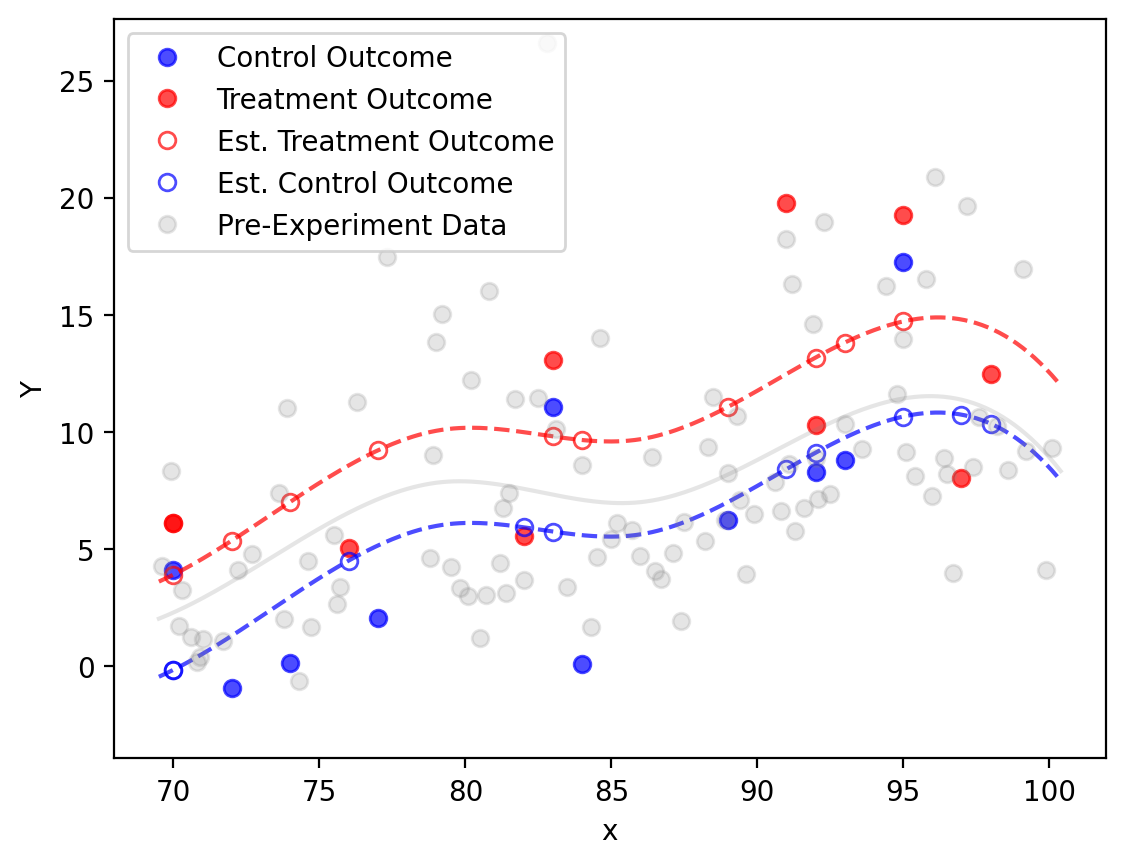

ATE:  4.062444996812863 , SE:  1.9137088734567829


In [10]:
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, pre_exp_dict = pre_exp_data, flip_alpha = False, save_name="nonnorm_plots/sec_cf.png")

In [11]:
sample_sizes = {1: 10, 2: 50, 3:100}
sim_num = 10000
te = 2
res = gen_distribution({'x': x, 'y': y}, pre_exp_data['model'], sample_sizes, sim_num, te)

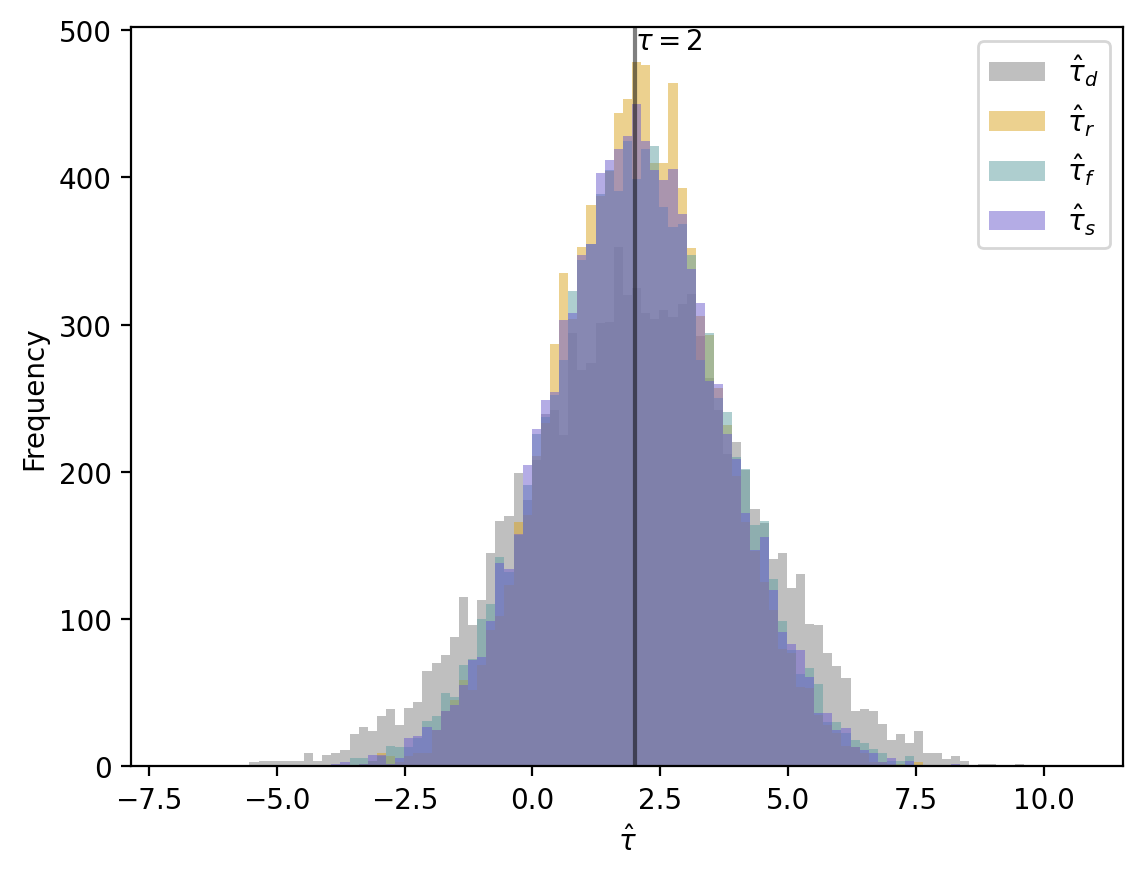

Sample size: 10 
ATE_d: 2.01 
ATE_r: 2.01 
ATE_ml: 2.01 
ATE_s: 2.01
Var_d: 4.982978319531313 
Var_red_r: 49.59% 
Var_red_ml:  39.07% 
Var__red_s: 43.55%


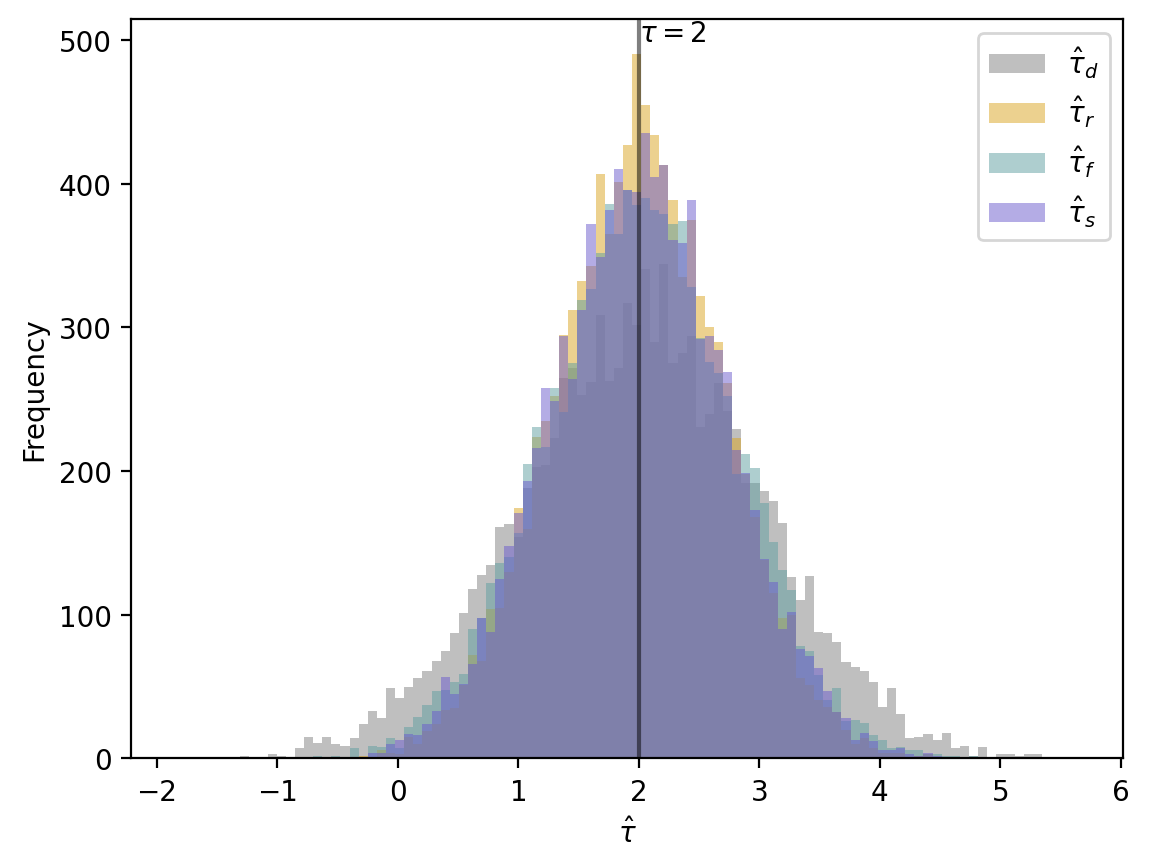

Sample size: 50 
ATE_d: 2.02 
ATE_r: 2.00 
ATE_ml: 2.00 
ATE_s: 2.00
Var_d: 0.9964406119297076 
Var_red_r: 51.59% 
Var_red_ml:  38.50% 
Var__red_s: 45.45%


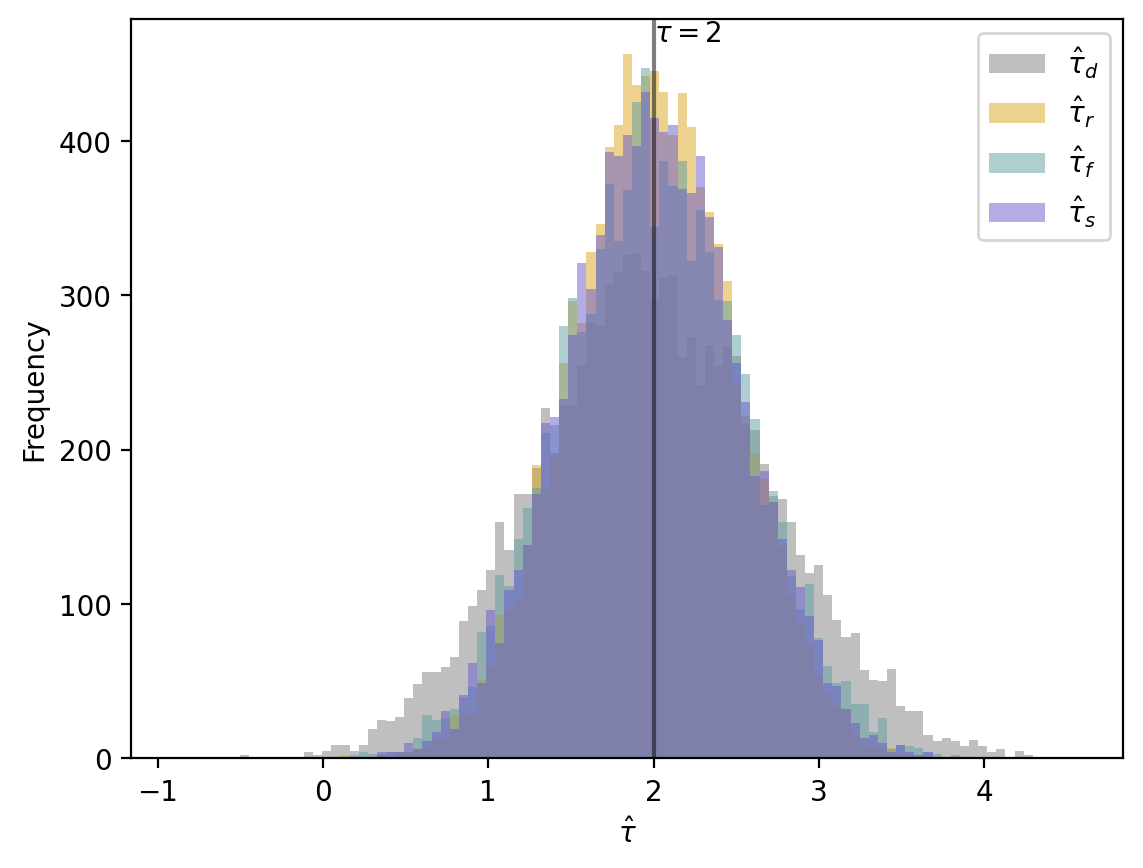

Sample size: 100 
ATE_d: 2.00 
ATE_r: 2.00 
ATE_ml: 2.00 
ATE_s: 1.99
Var_d: 0.5032875715515296 
Var_red_r: 52.53% 
Var_red_ml:  39.28% 
Var__red_s: 46.23%


In [12]:
# plot histograms of ATE for each method at each sample size
plot_ATE_distribution(res, te, sample_sizes, save_name="nonnorm_plots/sec")

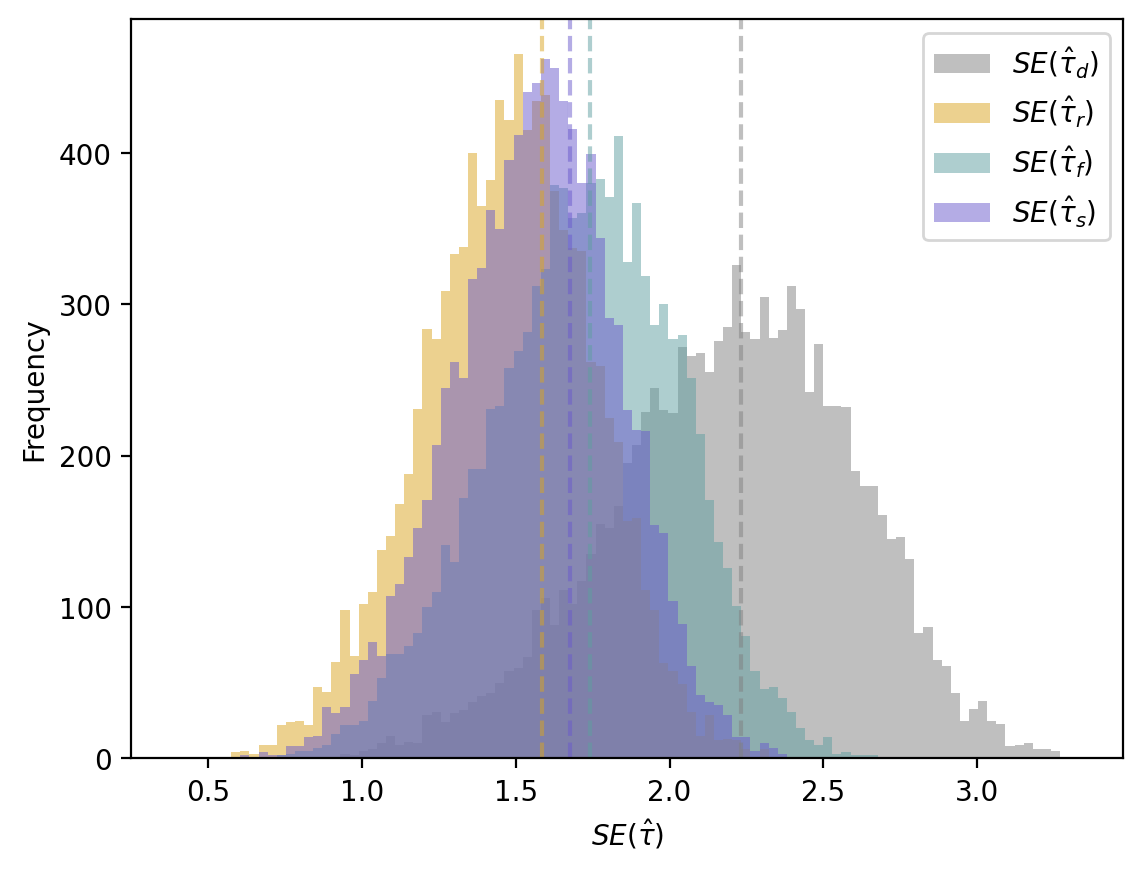

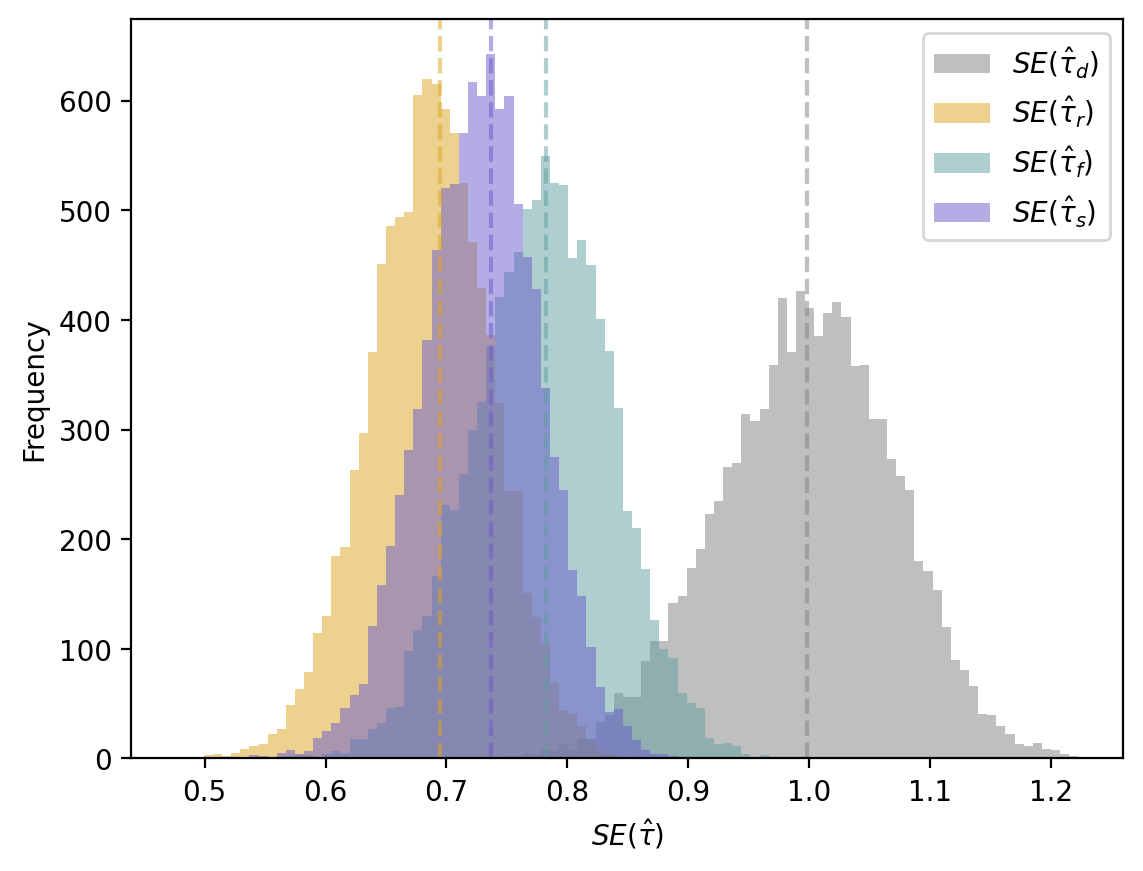

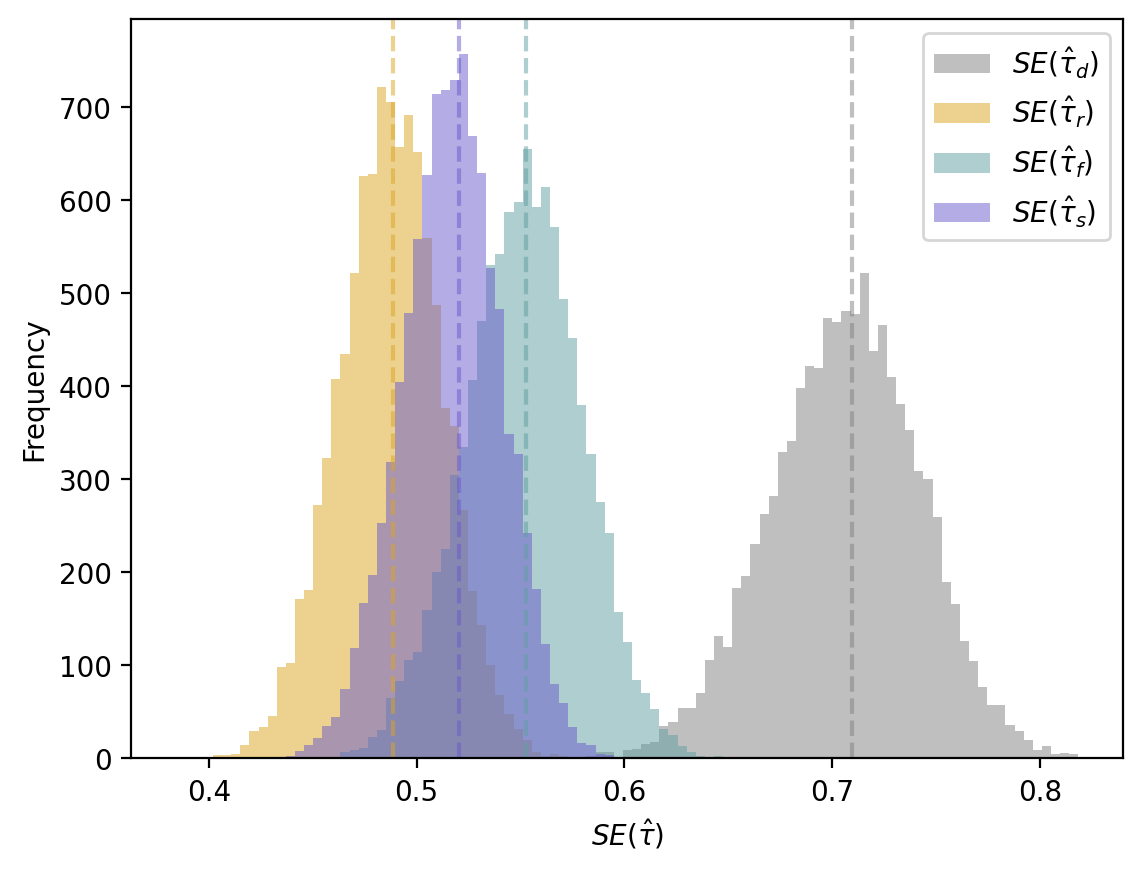

In [13]:
# plot histogram for SE for each method at each sample size
plot_SE_distribution(res, save_name="nonnorm_plots/sec")

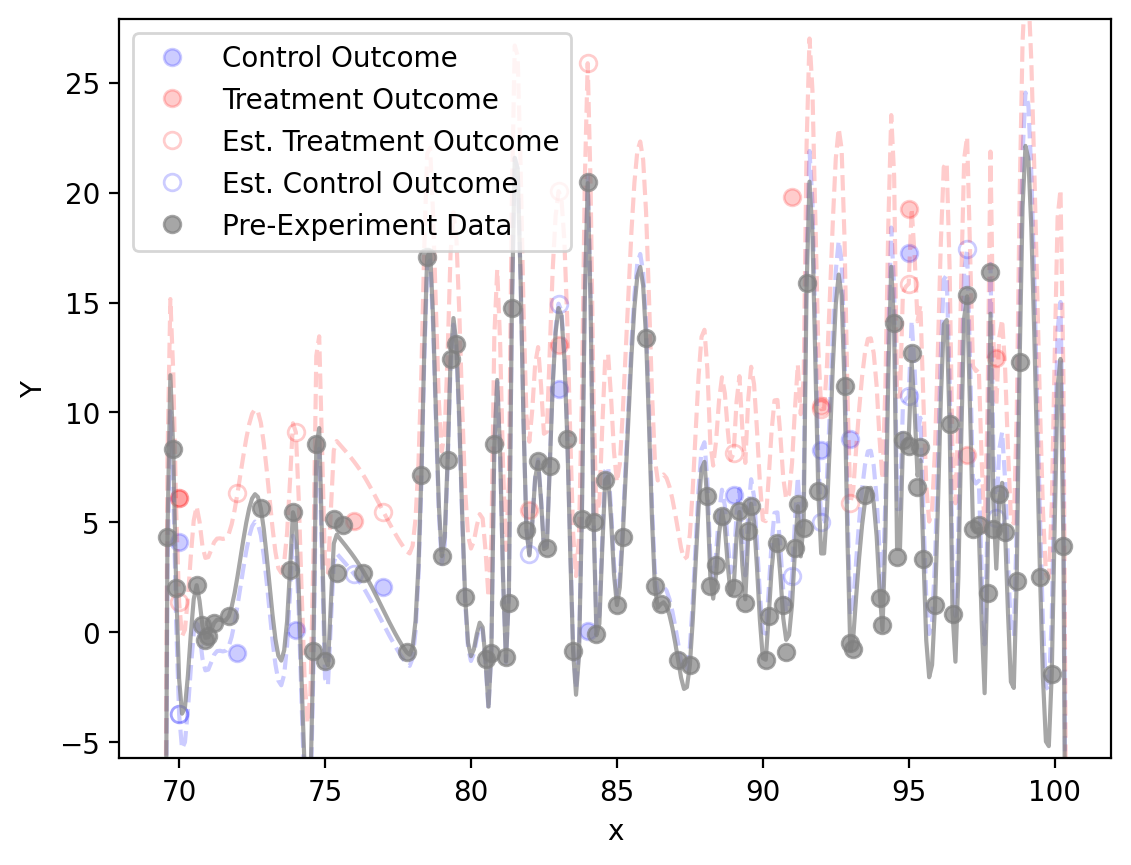

ATE:  5.114606201951904 , SE:  3.558292347963449


In [14]:
# now, we test our method with poor pre-experiment data. There is a huge misalignment between pre- and in-experiment data
np.random.seed(seed)
random.seed(seed)

# re-generate exp_data sample since its been replaced in above simulation
exp_data = gen_exp_data(x,y,small_sample_size,2)

pre_exp_data_poor = gen_pre_exp_data_poor()

def pre_exp_model_poor(x):
    mod = pre_exp_data_poor['model']
    return mod(x)

# linearly adjust poor predictions
treat_pred = pre_exp_model_poor(exp_data['treat_x'])
control_pred = pre_exp_model_poor(exp_data['control_x'])
control_r = exp_data['control_y'] - control_pred
treat_r = exp_data['treat_y'] - treat_pred
treatxvar = np.var(exp_data['treat_x'], ddof=1)
controlxvar = np.var(exp_data['control_x'], ddof=1)
treatxcov = np.cov(exp_data['treat_x'], treat_r, ddof=1)[0,1]
controlxcov = np.cov(exp_data['control_x'], control_r, ddof=1)[0,1]
beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
alpha_1 = np.mean(treat_r) - np.mean(exp_data['treat_x'])*beta
alpha_0 = np.mean(control_r) - np.mean(exp_data['control_x'])*beta

# define the two_stage model
def two_stage_mod_poor(x):
    mod = pre_exp_data_poor['model']
    return x * beta + mod(x)

cf_dict = gen_counter_data(pre_exp_data_poor['fine_x'], exp_data, two_stage_mod_poor, alpha_1, alpha_0)
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, pre_exp_dict = pre_exp_data_poor, flip_alpha = True, save_name="nonnorm_plots/sec2_preexp.png")

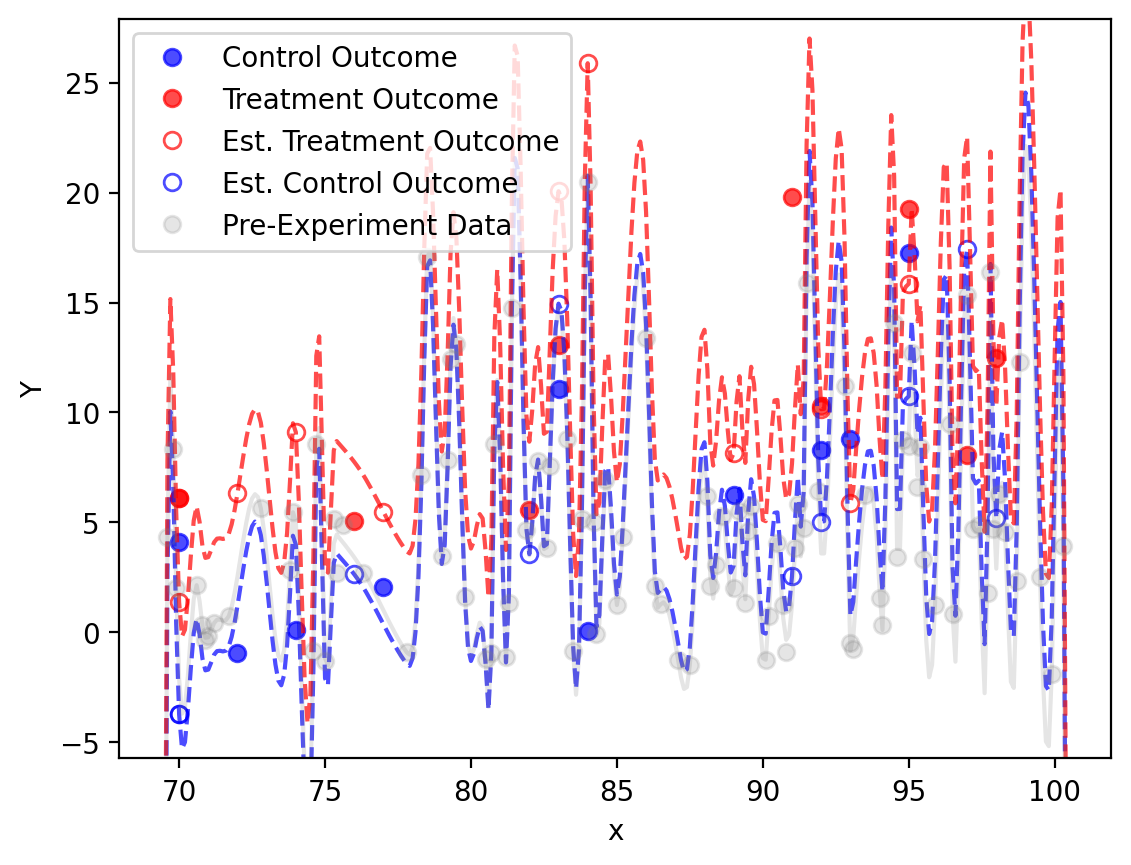

ATE:  5.114606201951904 , SE:  3.558292347963449


In [15]:
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, pre_exp_dict = pre_exp_data_poor, flip_alpha = False, save_name="nonnorm_plots/sec2_cf.png")

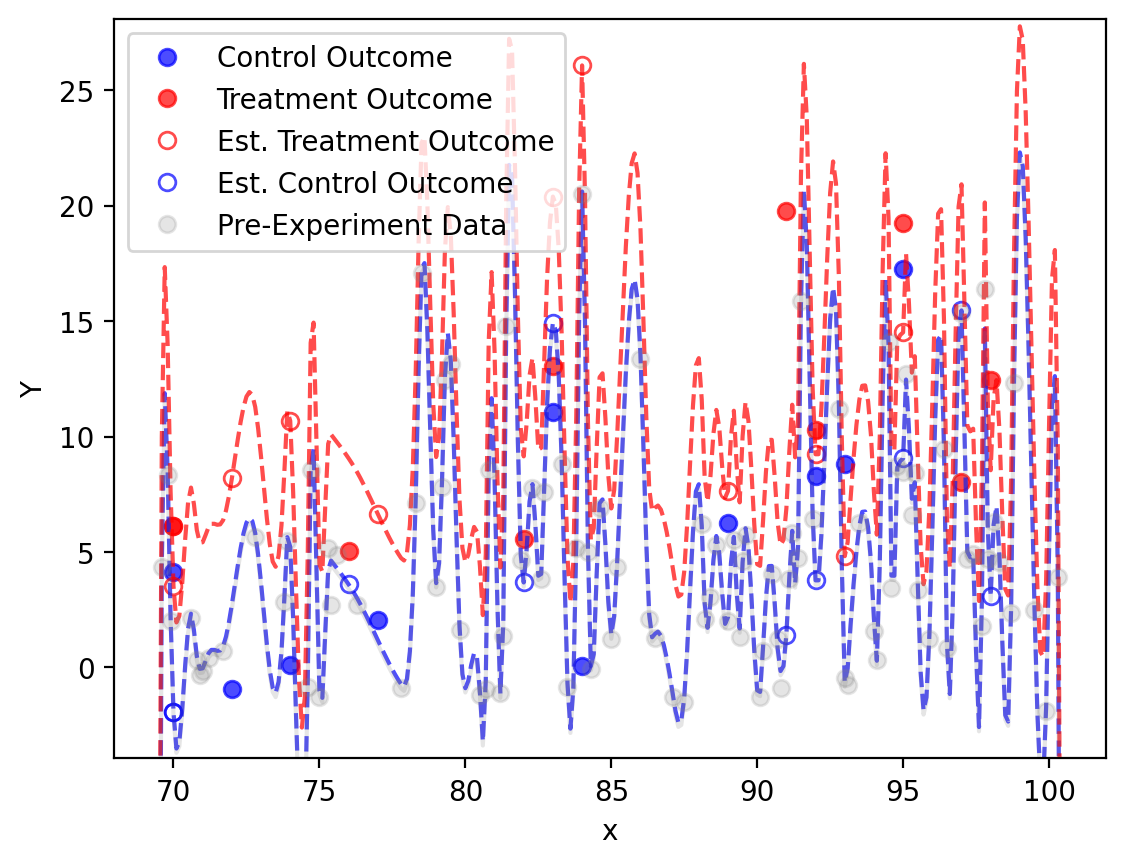

ATE:  5.462245510467651 , SE:  3.612502238368597


In [16]:
# generate plot for tau_f, without secondary adjustment to show how it does a poor job in producing counterfactuals
alpha_1 = np.mean(exp_data['treat_y']) - np.mean(pre_exp_model_poor(exp_data['treat_x']))
alpha_0 = np.mean(exp_data['control_y']) - np.mean(pre_exp_model_poor(exp_data['control_x']))
cf_dict = gen_counter_data(pre_exp_data_poor['fine_x'], exp_data, pre_exp_model_poor, alpha_1, alpha_0)
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, pre_exp_dict = pre_exp_data_poor, flip_alpha = False, save_name="nonnorm_plots/flex2_cf.png")

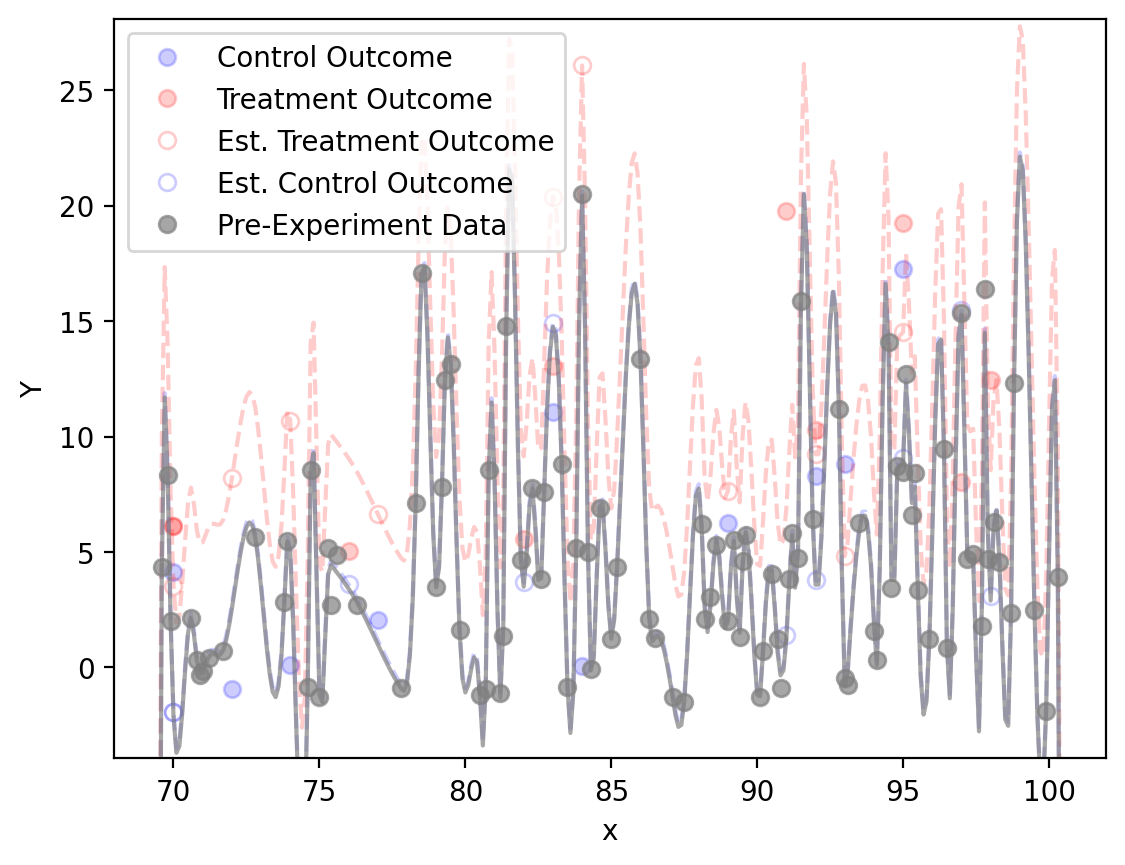

ATE:  5.462245510467651 , SE:  3.612502238368597


In [17]:
plot_instance(exp_data, 'x','Y', cf_dict = cf_dict, pre_exp_dict = pre_exp_data_poor, flip_alpha = True, save_name="nonnorm_plots/flex2_preexp.png")

In [18]:
res = gen_distribution({'x': x, 'y': y}, pre_exp_data_poor['model'], sample_sizes, sim_num, te)

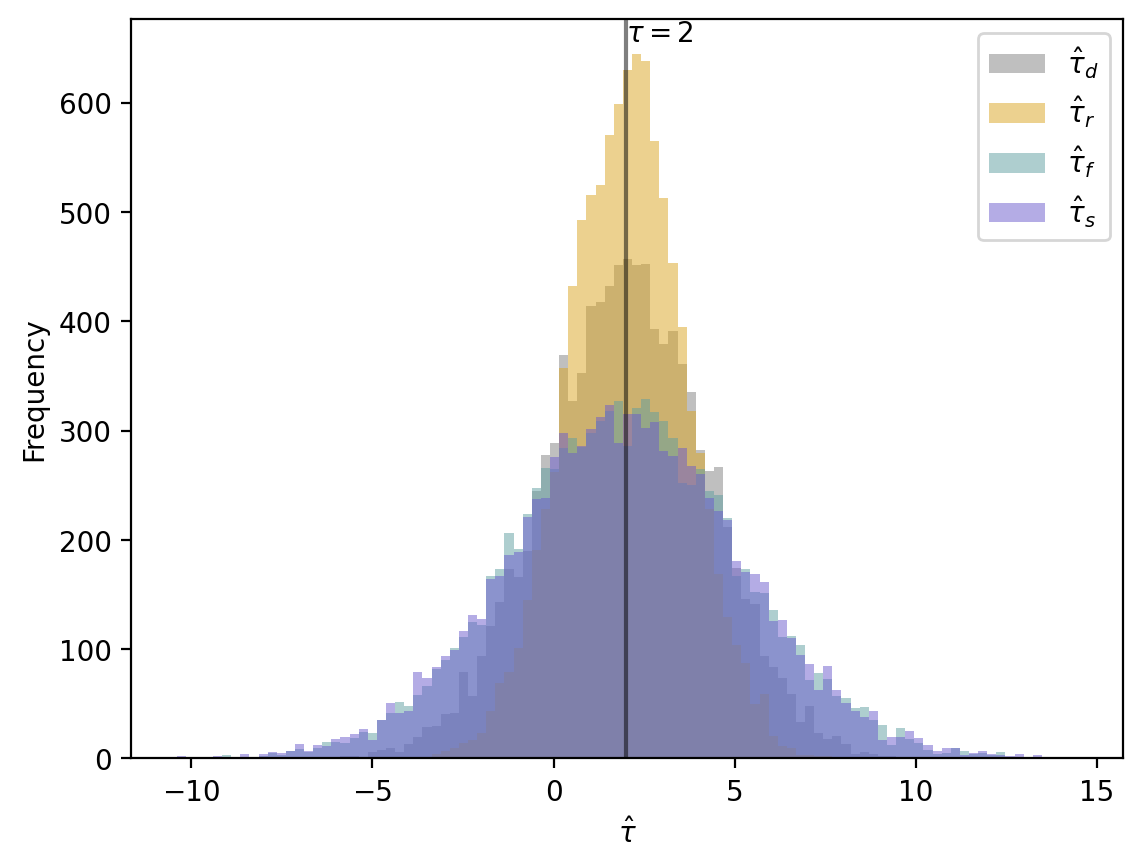

Sample size: 10 
ATE_d: 2.00 
ATE_r: 2.01 
ATE_ml: 1.99 
ATE_s: 1.99
Var_d: 5.070988537947191 
Var_red_r: 49.59% 
Var_red_ml:  -101.88% 
Var__red_s: -111.11%


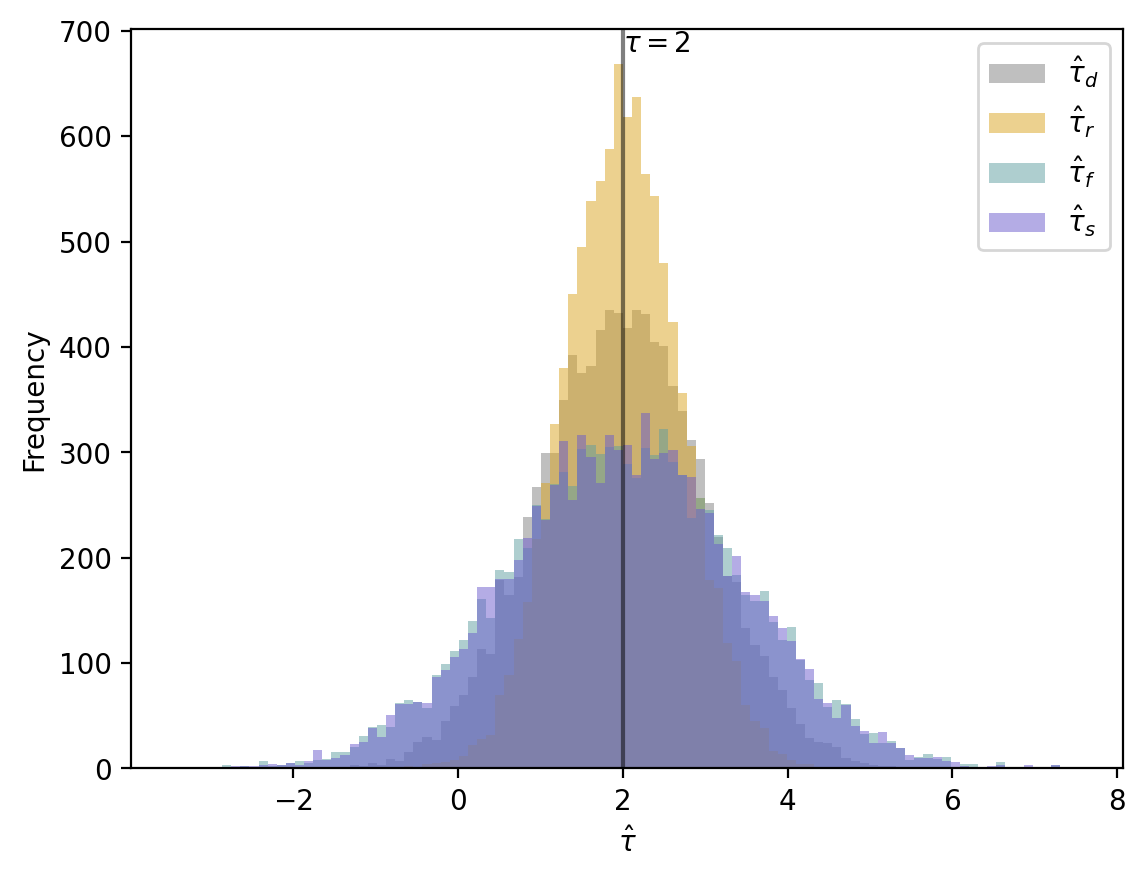

Sample size: 50 
ATE_d: 1.99 
ATE_r: 1.99 
ATE_ml: 2.01 
ATE_s: 2.01
Var_d: 1.002066381197302 
Var_red_r: 51.27% 
Var_red_ml:  -102.48% 
Var__red_s: -99.64%


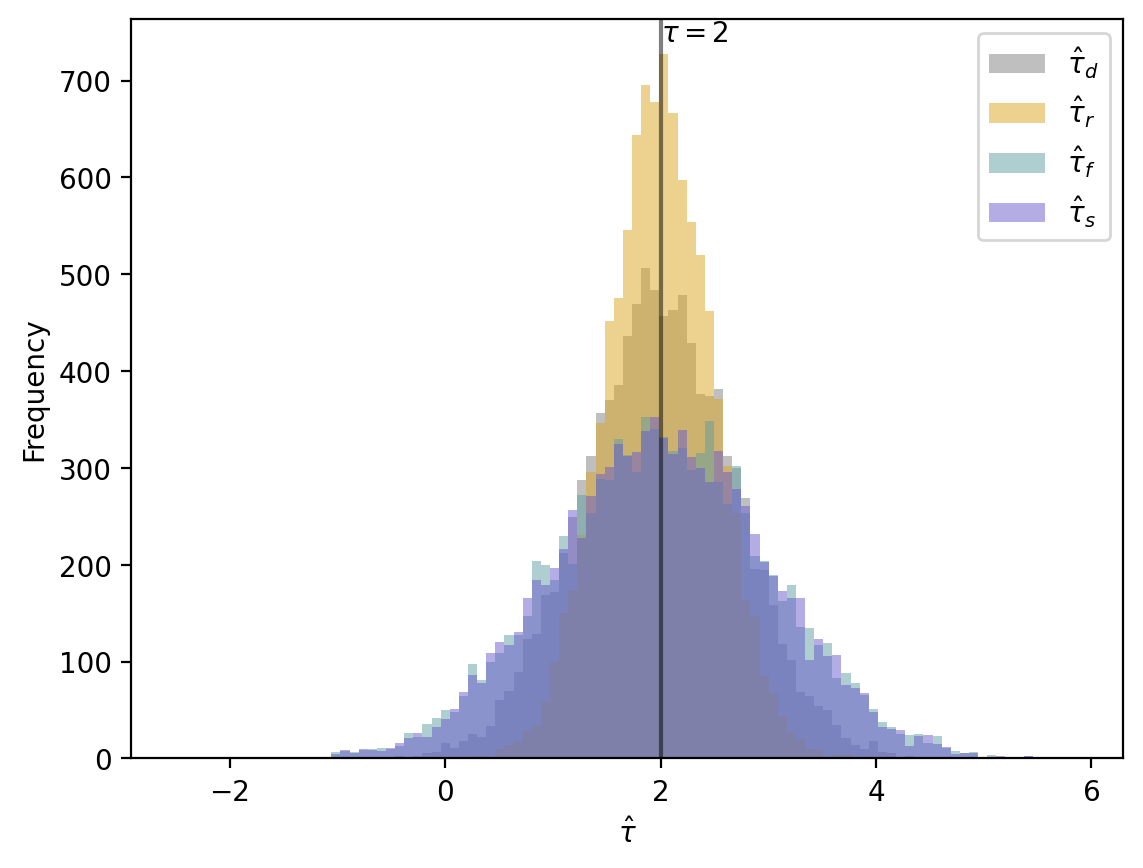

Sample size: 100 
ATE_d: 1.99 
ATE_r: 1.99 
ATE_ml: 2.01 
ATE_s: 2.01
Var_d: 0.5043566191172124 
Var_red_r: 52.59% 
Var_red_ml:  -104.75% 
Var__red_s: -99.25%


In [19]:
# plot histograms of ATE for each method at each sample size
plot_ATE_distribution(res, te, sample_sizes, save_name="nonnorm_plots/sec2")

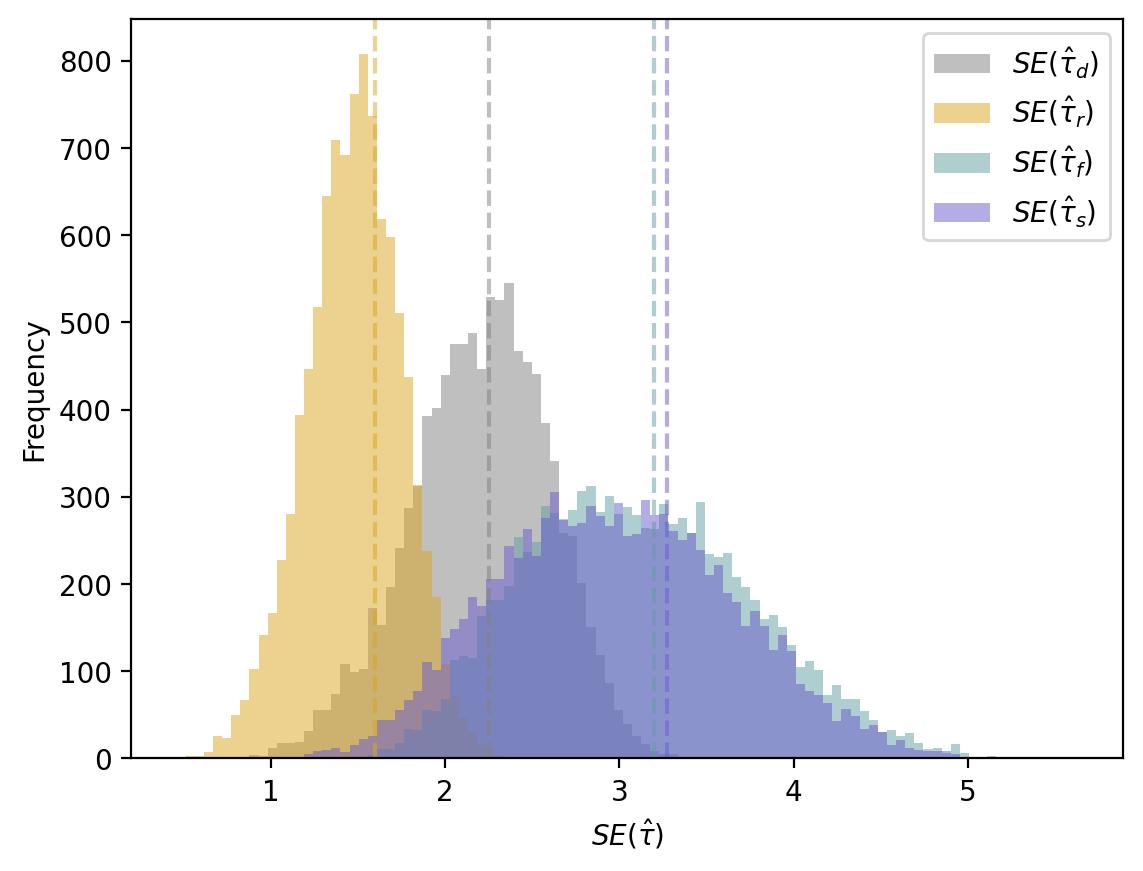

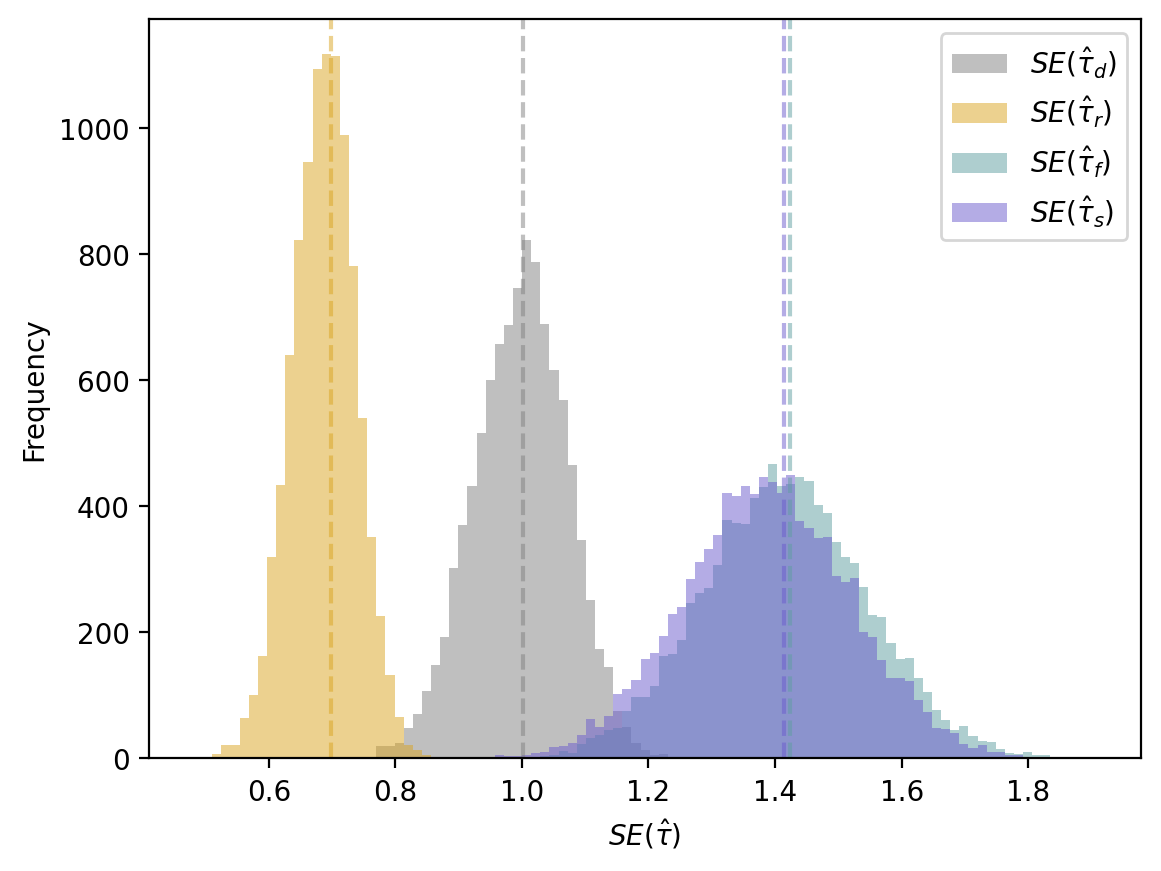

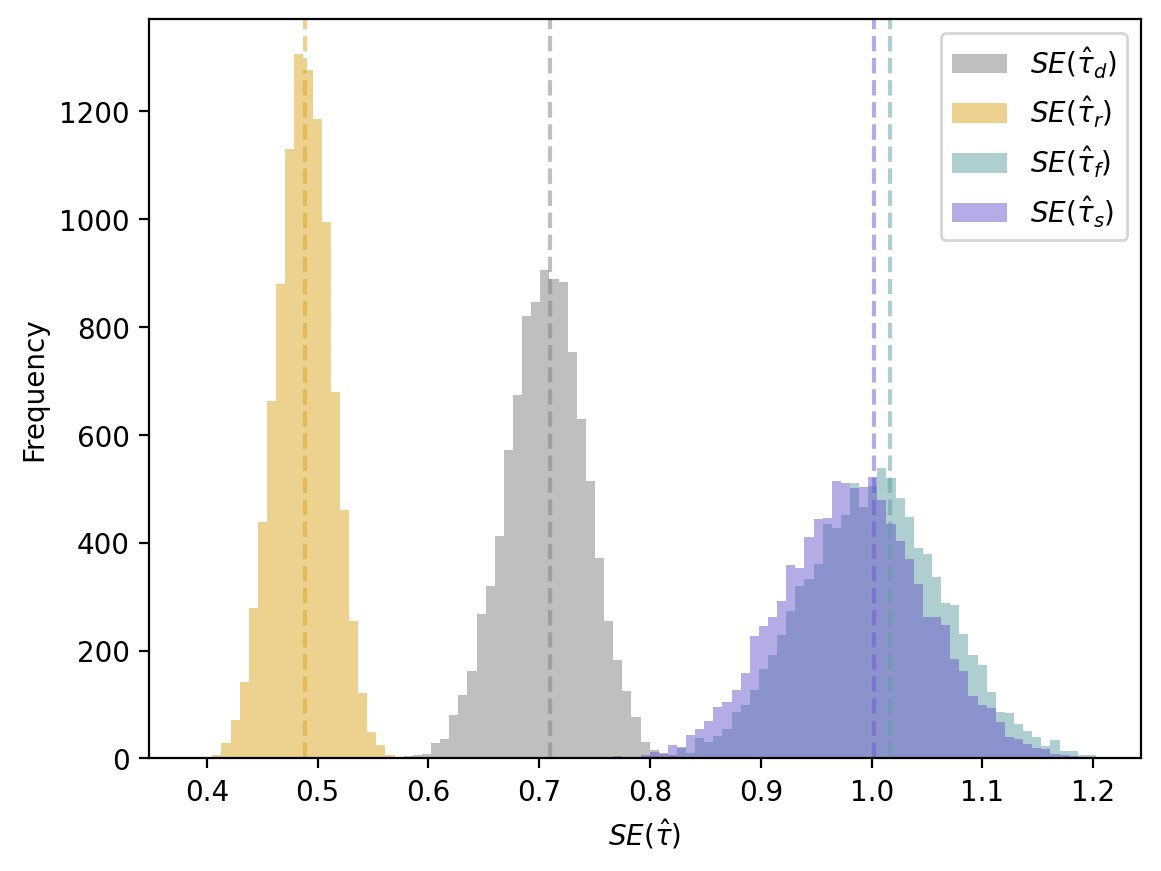

In [20]:
# plot histogram for SE for each method at each sample size
plot_SE_distribution(res, save_name="nonnorm_plots/sec2")